# Name : Fernando I.A.M.D.
# Index No.: 190172K

In [1]:
import cv2
import numpy as np
import sympy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy . optimize import minimize
from scipy import linalg
from numpy.linalg import inv
%matplotlib inline

## Q1

In [19]:
from math import sqrt
from scipy.stats import circstd

def dist(x1, y1, a, b, c):    
    d = abs((a * x1 + b * y1 + c)) / ((a * a + b * b)**0.5)
    return d

def findCircle(x1, y1, x2, y2, x3, y3) :
    x12 = x1 - x2
    x13 = x1 - x3
    y12 = y1 - y2
    y13 = y1 - y3 
    y31 = y3 - y1
    y21 = y2 - y1
    x31 = x3 - x1
    x21 = x2 - x1
 
 
    sx13 = pow(x1, 2) - pow(x3, 2)
    sy13 = pow(y1, 2) - pow(y3, 2)
    sx21 = pow(x2, 2) - pow(x1, 2)
    sy21 = pow(y2, 2) - pow(y1, 2)
 
    f = (((sx13) * (x12) + (sy13) *(x12) + (sx21) * (x13) +(sy21) * (x13)) // (2 *((y31) * (x12) - (y21) * (x13))))
             
    g = (((sx13) * (y12) + (sy13) * (y12) +(sx21) * (y13) + (sy21) * (y13)) //(2 * ((x31) * (y12) - (x21) * (y13))))
 
    c = (-pow(x1, 2) - pow(y1, 2) -2 * g * x1 - 2 * f * y1)
 
    h = -g
    k = -f
    sqr_of_r = h * h + k * k - c

    r = round(sqrt(sqr_of_r), 5)
 
    return (h, k),r


def ransacLine(x,y,N):
    Td =  1
    TiC = (N//2)*0.95
    print(TiC)

    iter = 10000
    max_in = 0
    model = (0,0)


    for i in range (iter):
        p = np.random.randint(0,len(y)) 
        q = np.random.randint(0,len(y))
        x1,x2,y1,y2 = x[p],x[q],y[p],y[q]
        if (x1!=x2):
            m1 = (y2 - y1) / (x2 - x1)
            c1 = y1 - m1 * x1 
            
        
            inl_cnt = 0
            for j in range(len(y)):
                a = dist(x[j],y[j],m1,-1,c1)
                if (a<=Td):
                    inl_cnt+=1
            # print(inl_cnt)
            if (inl_cnt>max_in and inl_cnt>TiC):
                max_in = inl_cnt
                model = (m1,c1)

    return model[0],model[1]

def ransacCircle(x,y,N):
    Td =  1
    TiC = (N//2)*0.95
    print(TiC)

    iter = 1000
    max_in = 0
    center = (0,0)
    radi = 0

    inl_x = np.array([])
    inl_y = np.array([])

    for i in range (iter):
        p = np.random.randint(0,len(y)) 
        q = np.random.randint(0,len(y))
        r = np.random.randint(0,len(y))

        x1,x2,x3,y1,y2,y3 = x[p],x[q],x[r],y[p],y[q],y[r]
        if (x1 != x2 and x2 != x3 and x1 != x3):
                cen,rad = findCircle(x1, y1, x2, y2, x3, y3)
                inl_cnt = 0
                for j in range(len(y)):
                    dist = ((x[j] - cen[0])**2 + (y[j] - cen[1])**2)**0.5
                    if (abs(dist-rad)<Td):
                            inl_cnt+=1
                
                if (inl_cnt>max_in):
                    max_in = inl_cnt
                    center,radi = cen,rad

    for k in range(len(y)):
                    dist = ((x[k] - center[0])**2 + (y[k] - center[1])**2)**0.5
                    if (abs(dist-rad)<Td):
                        np.append(inl_x,x[k])
                        np.append(inl_y,y[k])
    
    max_in = 0
    center = (0,0)
    radi = 0
    for i in range (iter):
        p = np.random.randint(0,len(inl_y)) 
        q = np.random.randint(0,len(inl_y))
        r = np.random.randint(0,len(inl_y))

        x1,x2,x3,y1,y2,y3 = inl_x[p],inl_x[q],inl_x[r],inl_y[p],inl_y[q],inl_y[r]
        if (x1 != x2 and x2 != x3 and x1 != x3):
                cen,rad = findCircle(x1, y1, x2, y2, x3, y3)
                inl_cnt = 0
                for j in range(len(y)):
                    dist = ((x[j] - cen[0])**2 + (y[j] - cen[1])**2)**0.5
                    if (abs(dist-rad)<Td):
                            inl_cnt+=1
                
                if (inl_cnt>max_in):
                    max_in = inl_cnt
                    center,radi = cen,rad

    return center,radi




23.75


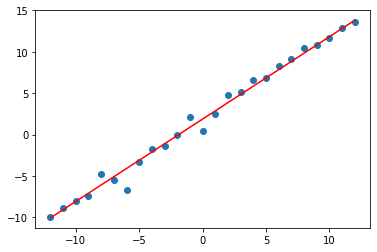

In [17]:
########## line ##############
N = 50
half_n = N//2
r = 10
s = r/16
x = np . linspace ( -12 , 12 , half_n )
m, b = 1, 2
y = m*x + b + s *np . random . randn ( half_n )
plt.scatter(x,y)

m1,c1 = ransacLine(x,y,N)

plt.plot(x,m1*x+c1,'r')
plt.show()

475.0


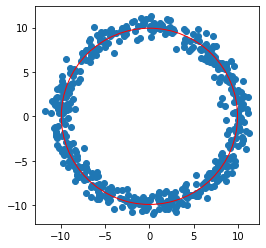

In [35]:
########## circle #############
N = 1000
half_n = N//2
r = 10
s = r/16
t = np . random . uniform ( 0 , 2*np . pi , half_n )
n = s *np . random . randn ( half_n )
x , y = ( r + n ) * np . cos ( t ) , ( r + n ) * np . sin ( t )

center,radi = ransacCircle(x,y,N)


figure, axes = plt.subplots()
plt.scatter(x,y)
aa = plt.Circle(center,radi,fill=False,color='r')
axes.set_aspect( 1 )
axes.add_artist(aa )
plt.show()

47.5


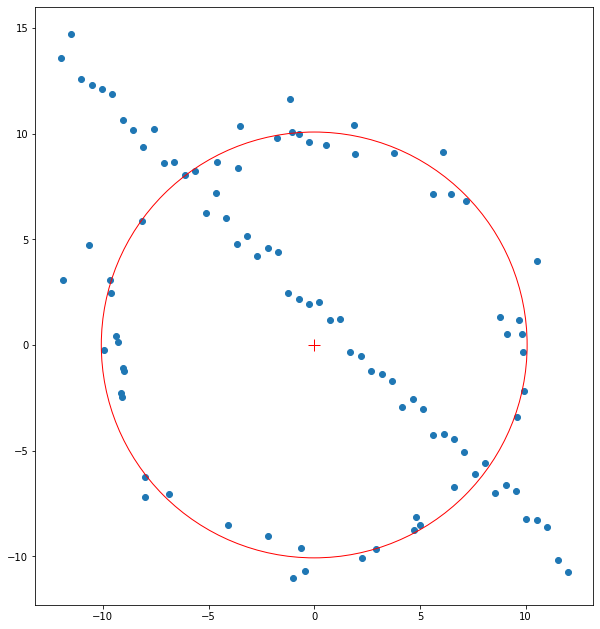

In [41]:
X_data, Y_data = [],[]
N = 100
half_n = N // 2
r = 10
s = r/16
t = np.random.uniform(0 , 2*np.pi , half_n )
n = s*np.random.randn(half_n)
x , y = (r+n)*np.cos(t),(r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n , 1 ) , y.reshape( half_n , 1 ) ) )
m, b = -1, 2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )
X_line = np.hstack((x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )
X = np.vstack(( X_circ , X_line ) )

for vals in X:
    X_data.append(vals[0])
    Y_data.append(vals[1])


center,radi = ransacCircle(X_data,Y_data,N)


figure, axes = plt.subplots(figsize = (11,11))
plt.scatter(X_data,Y_data)
aa = plt.Circle(center,radi,fill=False,color='r')
axes.set_aspect( 1 )
axes.add_artist(aa )
plt.plot(center[0],center[1], 'r', marker='+', markersize=12)
plt.show()



## Q2

(84, 492, 3)


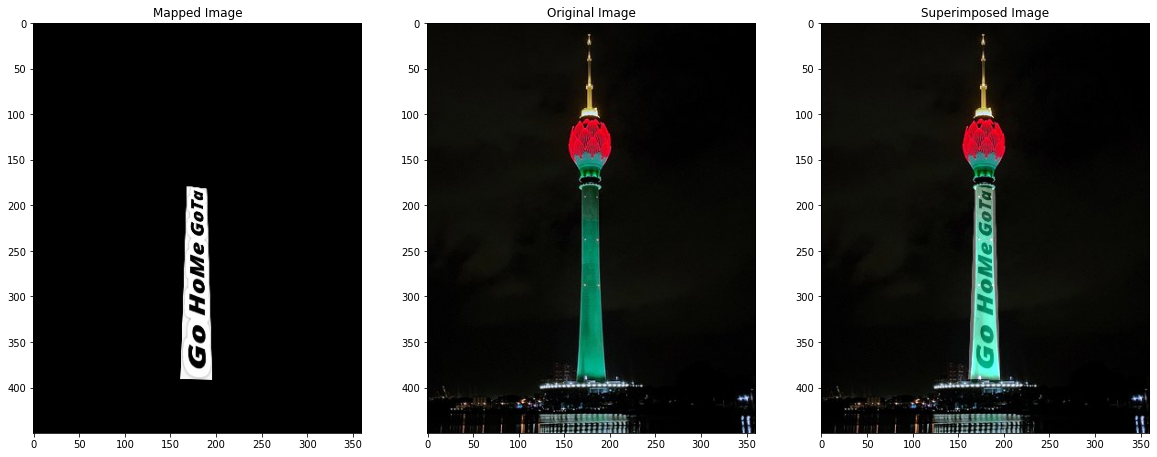

In [2]:
N = 4
global n
n = 0
pts_src = np.empty((N, 2))
pts_dst = np.empty((N, 2))

def draw_circle(event, x, y, flags, param):
    global n
    p = param[0]
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(param[1], (x, y), 5, (255, 0, 0), -1)
        p[n] = (x, y)
        n += 1

im_src = cv2.imread('1.jpg')
print(im_src.shape)
pts_src = np.array([[0, 0], [0,im_src.shape[0]], [im_src.shape[1], 0],[im_src.shape[1], im_src.shape[0]]])

im_dst = cv2.imread('towering-at-an-imposing.jpg')

im_dst_copy = im_dst.copy()
param = [pts_dst, im_dst_copy]
cv2.namedWindow("Select Points", cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback('Select Points', draw_circle, param)

while (1):
    cv2.imshow("Select Points", im_dst_copy)
    if n == N:
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()
h, status = cv2.findHomography(pts_src, pts_dst)
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

im_out1 = cv2.addWeighted(im_dst,1,im_out,.4,0)

fig, ax = plt.subplots(1,3,figsize= (20,10))

ax[0].imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))
ax[0].set_title("Mapped Image")
ax[1].imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB))
ax[1].set_title("Original Image")
ax[2].imshow(cv2.cvtColor(im_out1, cv2.COLOR_BGR2RGB))
ax[2].set_title("Superimposed Image")
plt.show()

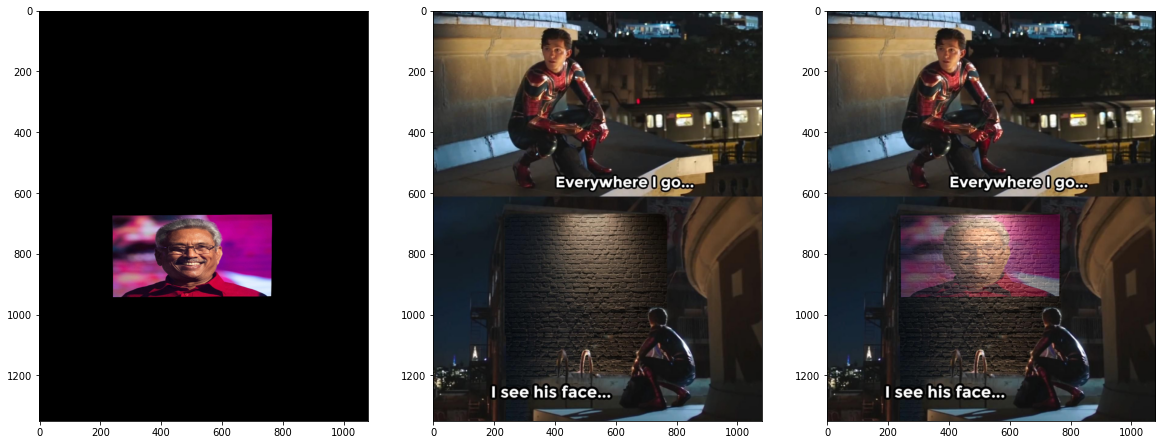

In [1]:
N = 4
global n
n = 0
pts_src = np.empty((N, 2))
pts_dst = np.empty((N, 2))

def draw_circle(event, x, y, flags, param):
    global n
    p = param[0]
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(param[1], (x, y), 5, (255, 0, 0), -1)
        p[n] = (x, y)
        n += 1

im_src = cv2.imread('gotabaya-rajapaksa-controversial-war-hero-who-ended-sri-lankas-3-decade-long-bloody-civil-conflict.jpg')
pts_src = np.array([[0, 0], [1200,0], [0, 900],[1200, 900]])

im_dst = cv2.imread('0542a568280eaff0cd2dfadbfa362ecd.jpg')

im_dst_copy = im_dst.copy()
param = [pts_dst, im_dst_copy]
cv2.namedWindow("Select Points", cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback('Select Points', draw_circle, param)

while (1):
    cv2.imshow("Select Points", im_dst_copy)
    if n == N:
        
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
h, status = cv2.findHomography(pts_src, pts_dst)
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

im_out1 = cv2.addWeighted(im_dst,1,im_out,.4,0)

fig, ax = plt.subplots(1,3,figsize= (20,10))

ax[0].imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(im_out1, cv2.COLOR_BGR2RGB))
plt.show()

## Q3

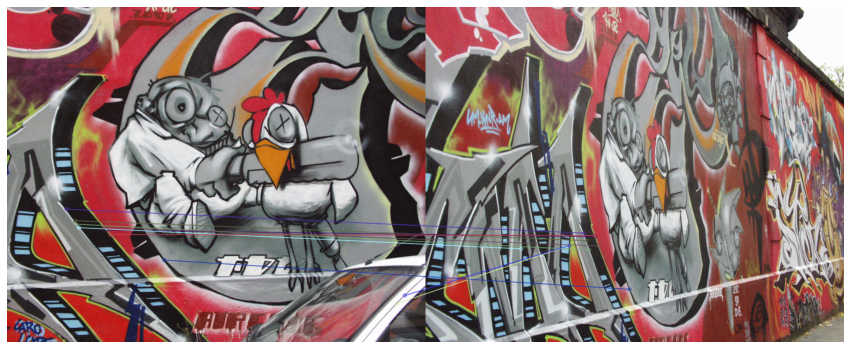

In [23]:
img1 = cv2.imread('img1.ppm')  
img2 = cv2.imread('img5.ppm') 



sift = cv2.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma = 1)

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

bf_match = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf_match.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

match_img = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:10], img2, flags=2)
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

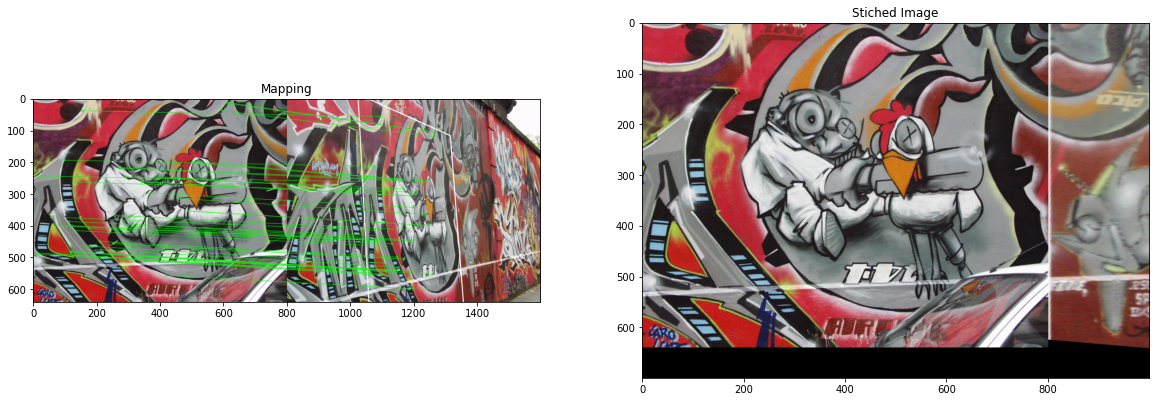

In [5]:
img1 = cv2.imread('img1.ppm')
img2 = cv2.imread('img5.ppm')

sift = cv2.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma =1)

keyPoints1, descriptors1 = sift.detectAndCompute(img1, None)
keyPoints2, descriptors2 = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

goodMatches = []
for m, n in matches:
    if m.distance < 0.86 * n.distance:
        goodMatches.append(m)
MIN_MATCH_COUNT = 10
if len(goodMatches) > MIN_MATCH_COUNT:
    sourcePoints = np.float32([keyPoints1[m.queryIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([keyPoints2[m.trainIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(sourcePoints, destinationPoints, method=cv2.RANSAC, ransacReprojThreshold=5.0)
    matchesMask = mask.ravel().tolist()
    h = img1.shape[0]
    w = img1.shape[1]
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, M)
    img2 = cv2.polylines(img2, [np.int32(transformedCorners)], True, (255, 255, 255), 2, cv2.LINE_AA)
else:
    matchesMask = None

drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matchesMask, flags=2)
result = cv2.drawMatches(img1, keyPoints1, img2, keyPoints2, goodMatches, None, **drawParameters)

im4_warped = cv2.warpPerspective(img2, np.linalg.pinv(M), (1000,700))
im4_warped[0:img1.shape[0], 0:img1.shape[1]] = img1

fig, ax = plt.subplots(1,2,figsize= (20,10))
ax[0].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax[0].set_title("Mapping")
ax[1].imshow(cv2.cvtColor(im4_warped, cv2.COLOR_BGR2RGB))
ax[1].set_title("Stiched Image")
plt.show()

